### **Todo lo estoy trabajando en notebooks antes de empezar a hacerlo con airflow para verificar que los datos realmente están funcionando correctamente, antes de automatizar estas tareas**

El MERGE es una de esas tareas que será necesaria en airflow, pero es la más compleja y por ende es mejor revisar antes de automatizar

In [2]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
print(os.getcwd())

try:
    os.chdir("../../workshop_02")

except FileNotFoundError:
    print("Directory not found or already exists.")
    
print(os.getcwd())

/home/edwards/Documentos/university/etl/workshop_02/notebooks
/home/edwards/Documentos/university/etl/workshop_02


In [3]:
grammys = pd.read_csv('data/grammys.csv')
api_artist = pd.read_csv('data/api_artist.csv')
spotify_dataset = pd.read_csv('data/processed/spotify_dataset_cleaned.csv')

Lo primero que hacemos es leer los archivos .csv que establecimos anteriormente

In [4]:
def normalize_name(name):
    """Normaliza nombres de artistas y canciones"""
    if pd.isna(name): return ""
    name = str(name).lower()
    name = re.sub(r'\(.*?\)|\[.*?\]|\{.*?\}', '', name)
    name = re.sub(r'\b(featuring|feat|ft)\b', '', name, flags=re.IGNORECASE)
    name = re.sub(r'&', ' ', name)
    name = re.sub(r'[^a-z0-9\s]', '', name)
    return ' '.join(name.split())

def normalize_spotify_artists(artists_str):
    """Normaliza artistas principales de Spotify"""
    if pd.isna(artists_str): return ""
    primary_artist = str(artists_str).split(';')[0]
    return normalize_name(primary_artist)

Luego lo que hacemos es crear unas expresiones regulares que estarań dentro de unas funciones para que se cumplan con ciertos parametros en los nombres y no haya problema al hacer el join

In [5]:
grammys['artist_normalized'] = grammys['artist'].apply(normalize_name)
grammys['nominee_normalized'] = grammys['nominee'].apply(normalize_name)

spotify_dataset['artists_normalized_primary'] = spotify_dataset['artists'].apply(normalize_spotify_artists)
spotify_dataset['track_name_normalized'] = spotify_dataset['track_name'].apply(normalize_name)
spotify_dataset['album_name_normalized'] = spotify_dataset['album_name'].apply(normalize_name)

Aplicamos las funciones a las columnas que queremos normalizar. Les cambiamos el nombre temporalmente, pero luego van a mantener el nombre original

In [6]:
combined_spotify = pd.merge(
    spotify_dataset,
    api_artist[['track_id', 'artist_name', 'artist_followers', 'artist_popularity', 'artist_id']],
    on='track_id',
    how='inner'
).drop_duplicates(subset=['track_id'])

grammy_nominations_by_work = grammys.groupby(
    ['artist_normalized', 'nominee_normalized']
).size().reset_index(name='work_grammy_nominations')

En el código anterior agrupamos a partir de track_id y con un inner join para tomar solo los valores que coincidan y si hay duplicados los eliminamos, agrupamos grammys por artista y nominados.

+ Anteriormente en api_spotify_003.ipynb eliminamos los nombres de los artistas que estaban nulos, debido a que una canción puede tener el mismo nombre pero diferente artista y sino conocemos al verdaderp artista podemos sesgar los datos

In [7]:
merged_step1 = pd.merge(
    combined_spotify,
    grammy_nominations_by_work,
    left_on=['track_name_normalized'],
    right_on=['nominee_normalized'],
    how='left'
)

merged_step2 = pd.merge(
    merged_step1,
    grammy_nominations_by_work,
    left_on=['album_name_normalized'],
    right_on=['nominee_normalized'],
    how='left',
    suffixes=('_track', '_album')
)

for col in ['work_grammy_nominations_track', 'work_grammy_nominations_album', 
            'artist_normalized_track', 'artist_normalized_album', 'artists_normalized_primary']:
    merged_step2[col] = merged_step2[col].fillna(0 if 'nominations' in col else '')

El primer paso lo que hace es unir a partir del nombre la canción nominada y el segundo unir a partir del album nominado.

Por último reemplazamos los valores nulos (en dado caso que existan) en las columnas númericas que creamos por un 0

In [8]:
cond_track_match = (
    (merged_step2['work_grammy_nominations_track'] > 0) &
    merged_step2.apply(lambda row: row['artists_normalized_primary'] in row['artist_normalized_track'], axis=1)
)

cond_album_match = (
    (merged_step2['work_grammy_nominations_album'] > 0) &
    merged_step2.apply(lambda row: row['artists_normalized_primary'] in row['artist_normalized_album'], axis=1)
)

merged_step2['track_grammy_nominations'] = np.where(cond_track_match, merged_step2['work_grammy_nominations_track'], 0).astype(int)
merged_step2['album_grammy_nominations'] = np.where(cond_album_match, merged_step2['work_grammy_nominations_album'], 0).astype(int)
merged_step2['has_grammy_nomination'] = (merged_step2['track_grammy_nominations'] > 0) | (merged_step2['album_grammy_nominations'] > 0)

Verificamos que el track tenga al menos una nominación y verificamos si el nombre del artista o album aparece en cualquier parte del dataframe.

+ Si se cumple la condición se coloca el número de nominaciones, sino colocamos 0


In [9]:
final_columns = [
    'track_id', 'artists', 'album_name', 'track_name', 'popularity', 'explicit',
    'danceability', 'energy', 'genre_category', 'duration_min',
    'artist_name', 'artist_followers', 'artist_popularity',
    'has_grammy_nomination', 'track_grammy_nominations', 'album_grammy_nominations'
]

cols_to_drop = [col for col in merged_step2.columns if col not in final_columns]
final_df = merged_step2.drop(columns=cols_to_drop)

if not final_df.empty:
    nom_sum = final_df['track_grammy_nominations'] + final_df['album_grammy_nominations']
    final_df = final_df.loc[nom_sum.groupby(final_df['track_id']).idxmax()]

Aquí al final nos quedamos con las columnas que queremos y eliminamos los duplicados de las filas de nominaciones y nos quedamos con las que tenga más nominaciones.

In [85]:
final_df.to_csv('data/merge_dataset.csv', index=False)

Guardamos el archivo

In [12]:
df = pd.read_csv('data/merge_dataset.csv')

In [87]:
print(f"\nDimensiones del DataFrame (Filas, Columnas): {df.shape}")

df.info()

print(df.columns.tolist())


Dimensiones del DataFrame (Filas, Columnas): (89740, 15)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89740 entries, 0 to 89739
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   track_id               89740 non-null  object 
 1   artists                89740 non-null  object 
 2   album_name             89740 non-null  object 
 3   track_name             89740 non-null  object 
 4   popularity             89740 non-null  int64  
 5   explicit               89740 non-null  bool   
 6   danceability           89740 non-null  float64
 7   energy                 89740 non-null  float64
 8   genre_category         89740 non-null  object 
 9   duration_min           89740 non-null  float64
 10  artist_name            89740 non-null  object 
 11  artist_followers       89740 non-null  int64  
 12  artist_popularity      89740 non-null  int64  
 13  has_grammy_nomination  89740 non-null  bool   
 

Vemos que tenemos un dataset con 89741 datos y 15 columnas a diferencia del primer dataset de spotify que tenía 22 columnas

In [88]:
df.head(20)

,track_id,artists,album_name,track_name,popularity,explicit,danceability,energy,genre_category,duration_min,artist_name,artist_followers,artist_popularity,has_grammy_nomination,grammy_nominations
0,0000vdrevcvmxbqtks888c,rill,lolly,lolly,44,True,0.91,0.37,world/regional,2.68,rill,27414,49,False,0
1,000cc8eparg64omtxvnz0p,glee cast,glee love songs,it's all coming back to me now (glee cast vers...,47,False,0.27,0.52,electronic,5.38,glee cast,1537680,70,False,0
2,000iz0k615uepwsj5z2re5,paul kalkbrenner;pig&dan,x,böxig leise - pig & dan remix,22,False,0.69,0.56,electronic,8.59,paul kalkbrenner,1289603,64,False,0
3,000qpdoc97imtbvf8gwcpy,paul kalkbrenner,zeit,tief,19,False,0.52,0.43,electronic,5.52,paul kalkbrenner,1289603,64,False,0
4,000rdcyioltexcutojewey,jordan sandhu,teeje week,teeje week,62,False,0.68,0.77,hip-hop/r&b,3.17,jordan sandhu,5128900,65,False,0
5,0017ximkqbtff2auozlhj6,chad daniels,busy being awesome,thanksgiving chicken,24,True,0.54,0.78,kids/comedy,2.12,chad daniels,38576,43,False,0
6,001apmdol3qtx1526t11n1,pink sweat$;kirby,new rnb,better,0,False,0.61,0.47,other,2.94,pink sweat$,1860364,65,False,0
7,001pyq8flnsl1c8ornli0b,old crow medicine show,o.c.m.s.,poor man,30,False,0.58,0.29,folk/acoustic,3.58,old crow medicine show,447894,54,False,0
8,001yqlndsduxd5lgbd66gt,soda stereo,soda stereo (remastered),el tiempo es dinero - remasterizado 2007,38,False,0.55,0.92,rock,2.95,soda stereo,9640864,76,False,0
9,002qpsulhhaw6dgqfxbao1,tokyo ghetto pussy,disco 2001,love generation,17,False,0.53,0.95,other,6.84,tokyo ghetto pussy,12487,32,False,0


Revisamos las primeras 20 filas de dataset

In [89]:
df.isnull().sum()

track_id                 0
artists                  0
album_name               0
track_name               0
popularity               0
explicit                 0
danceability             0
energy                   0
genre_category           0
duration_min             0
artist_name              0
artist_followers         0
artist_popularity        0
has_grammy_nomination    0
grammy_nominations       0
dtype: int64

Miramos si hay valores nulos, vemos que no hay ninguno, debido a que en los notebooks anteriores manejamos esto

In [90]:
pd.set_option('display.float_format', '{:,.2f}'.format)
df.describe().round(2)

,popularity,danceability,energy,duration_min,artist_followers,artist_popularity,grammy_nominations
count,"89,740.00","89,740.00","89,740.00","89,740.00","89,740.00","89,740.00","89,740.00"
mean,33.20,0.56,0.63,3.82,"3,000,524.70",52.44,0.02
std,20.58,0.18,0.26,1.88,"10,182,882.52",18.69,0.13
min,0.00,0.00,0.00,0.14,0.00,0.00,0.00
25%,19.00,0.45,0.46,2.88,"39,891.00",41.00,0.00
50%,33.00,0.58,0.68,3.55,"239,159.00",54.00,0.00
75%,49.00,0.69,0.85,4.40,"1,397,909.00",66.00,0.00
max,100.00,0.98,1.00,87.29,"142,469,822.00",100.00,3.00


Miramos las métricas principales de las columnas númericas

In [91]:
df['genre_category'].value_counts()

electronic                17736
other                     11463
world/regional             9766
rock                       8300
latin                      7224
pop                        7077
classical/instrumental     5482
kids/comedy                4849
metal                      4829
folk/acoustic              3366
anime/japanese             3214
country                    1927
hip-hop/r&b                1776
jazz/blues                 1462
reggae/dancehall           1269
Name: genre_category, dtype: int64

Vemos cuales son los valores de géneros músicales que más se repiten y nos damos cuenta que es la electrónica

In [93]:
df.describe()

,popularity,danceability,energy,duration_min,artist_followers,artist_popularity,grammy_nominations
count,"89,740.00","89,740.00","89,740.00","89,740.00","89,740.00","89,740.00","89,740.00"
mean,33.20,0.56,0.63,3.82,"3,000,524.70",52.44,0.02
std,20.58,0.18,0.26,1.88,"10,182,882.52",18.69,0.13
min,0.00,0.00,0.00,0.14,0.00,0.00,0.00
25%,19.00,0.45,0.46,2.88,"39,891.00",41.00,0.00
50%,33.00,0.58,0.68,3.55,"239,159.00",54.00,0.00
75%,49.00,0.69,0.85,4.40,"1,397,909.00",66.00,0.00
max,100.00,0.98,1.00,87.29,"142,469,822.00",100.00,3.00


Text(0, 0.5, '')

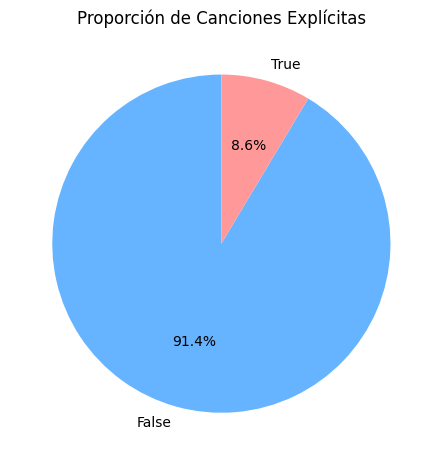

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
df['explicit'].value_counts().plot.pie(autopct='%1.1f%%', 
                                      colors=['#66b3ff','#ff9999'],
                                      startangle=90)
plt.title('Proporción de Canciones Explícitas')
plt.ylabel('')

Vemos que la mayoría de canciones no son explicitas un 91.4% mientras que el resto si que lo son


Text(0, 0.5, '')

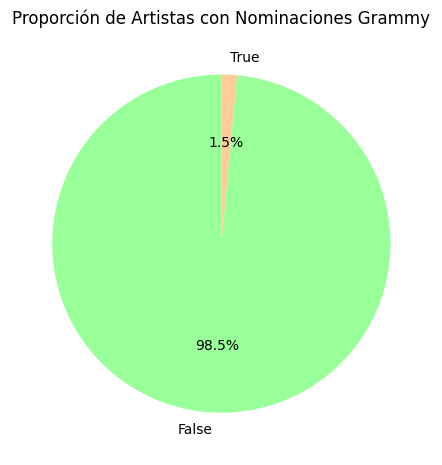

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
df['has_grammy_nomination'].value_counts().plot.pie(autopct='%1.1f%%', 
                                                   colors=['#99ff99','#ffcc99'],
                                                   startangle=90)
plt.title('Proporción de Artistas con Nominaciones Grammy')
plt.ylabel('')

El gráfico anterior muestra realmente la realidad de lo que es ser nominado a un grammy, pues solo el 1.5% de artistas y albumes que hay en el dataset fueron nomidados

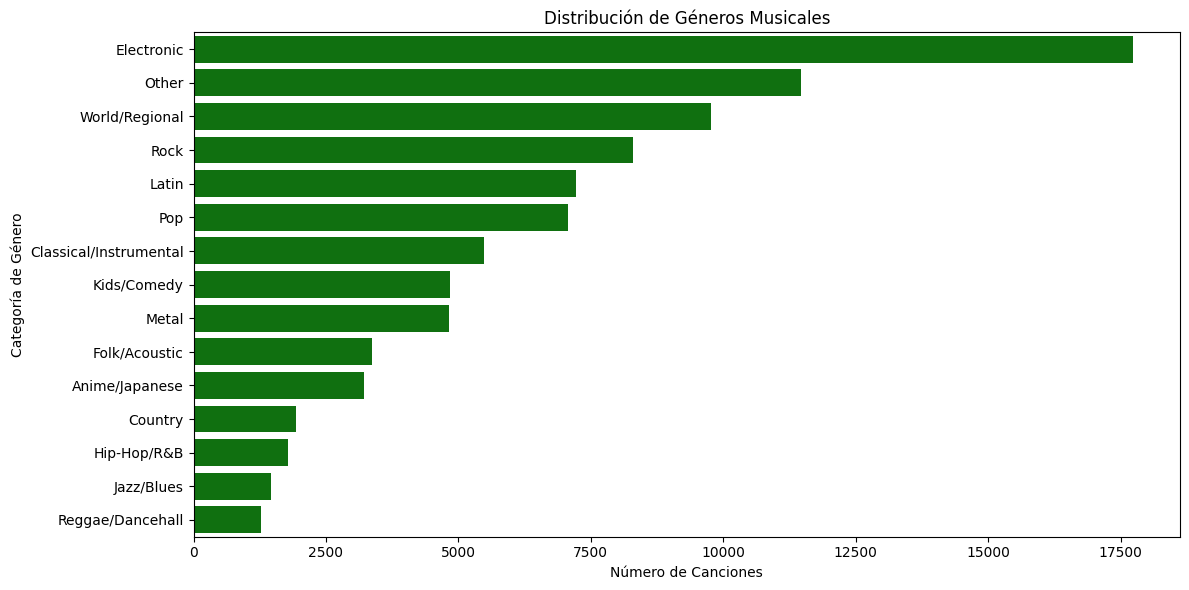

In [14]:
plt.figure(figsize=(12, 6))
genre_order = df['genre_category'].value_counts().index
sns.countplot(data=df, y='genre_category', order=genre_order, color='green')
plt.title('Distribución de Géneros Musicales')
plt.xlabel('Número de Canciones')
plt.ylabel('Categoría de Género')
plt.tight_layout()
plt.show()

Vemos que el género que más se repite es la electrónica

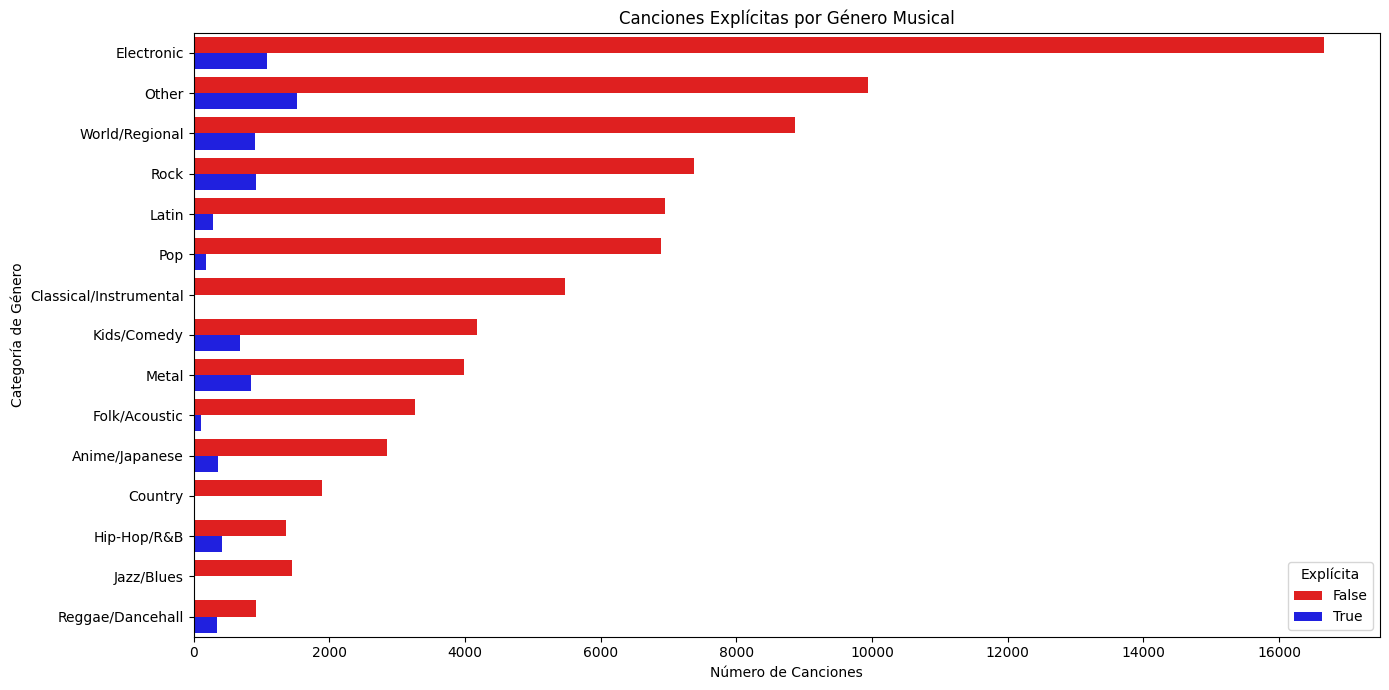

In [18]:
plt.figure(figsize=(14, 7))
sns.countplot(data=df, y='genre_category', hue='explicit', 
              order=genre_order, palette=['red','blue'])
plt.title('Canciones Explícitas por Género Musical')
plt.xlabel('Número de Canciones')
plt.ylabel('Categoría de Género')
plt.legend(title='Explícita', loc='lower right')
plt.tight_layout()
plt.show()

Hay muy pocas canciones explicitas por género pero en general la categoria other que cotiene generos como el country es la que más canciones explicitas tiene

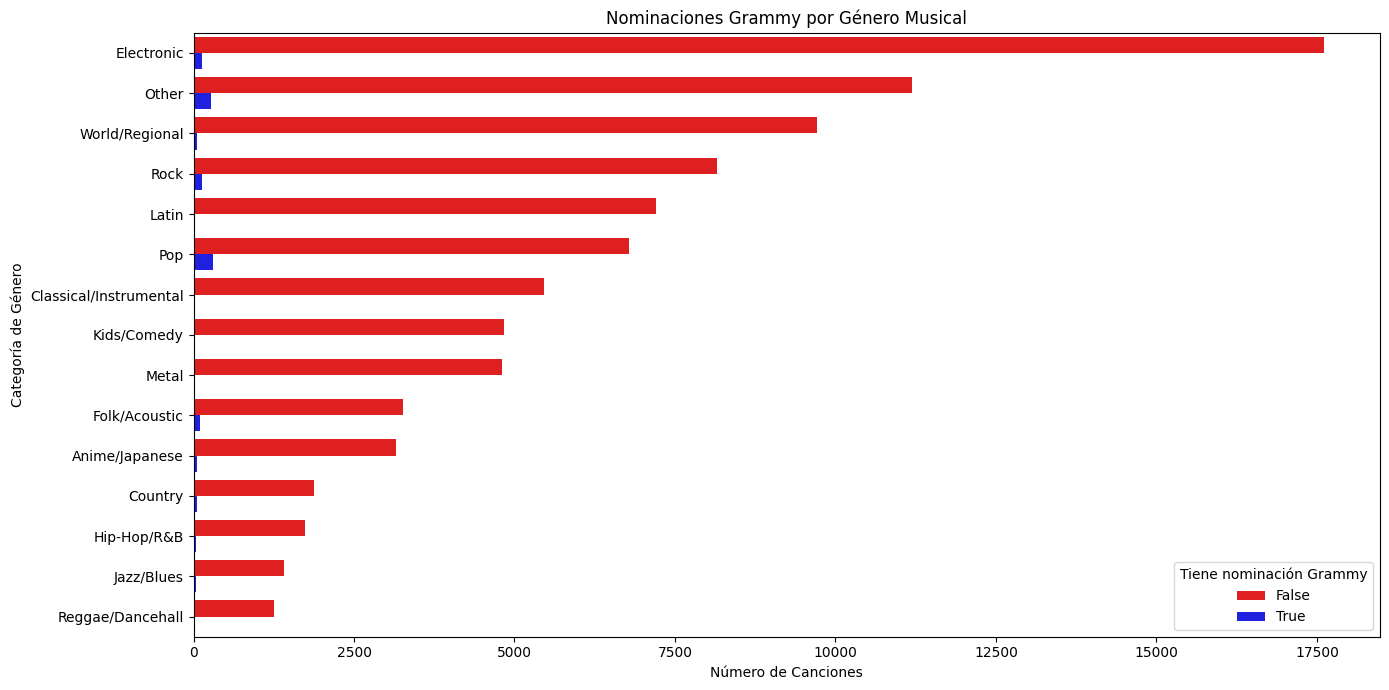

In [19]:
plt.figure(figsize=(14, 7))
sns.countplot(data=df, y='genre_category', hue='has_grammy_nomination', 
              order=genre_order, palette=['red','blue'])
plt.title('Nominaciones Grammy por Género Musical')
plt.xlabel('Número de Canciones')
plt.ylabel('Categoría de Género')
plt.legend(title='Tiene nominación Grammy', loc='lower right')
plt.tight_layout()
plt.show()

El pop es el más nominado a los grammys, mientras que el Reggae/Dancehall parecen no tener ni una nominación

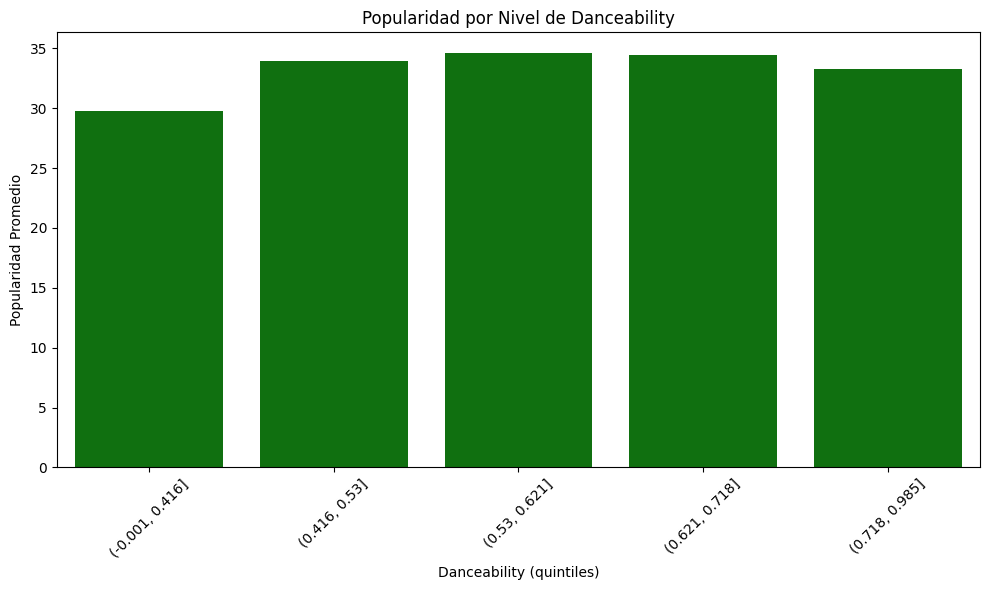

In [20]:
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x=pd.qcut(df['danceability'], q=5), y='popularity', 
            color='green', errorbar=None)
plt.title('Popularidad por Nivel de Danceability')
plt.xlabel('Danceability (quintiles)')
plt.ylabel('Popularidad Promedio')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Si la canción es bailable a nivel intermedio tiende a tener mayor popularidad, pero realmente no varía demasiado

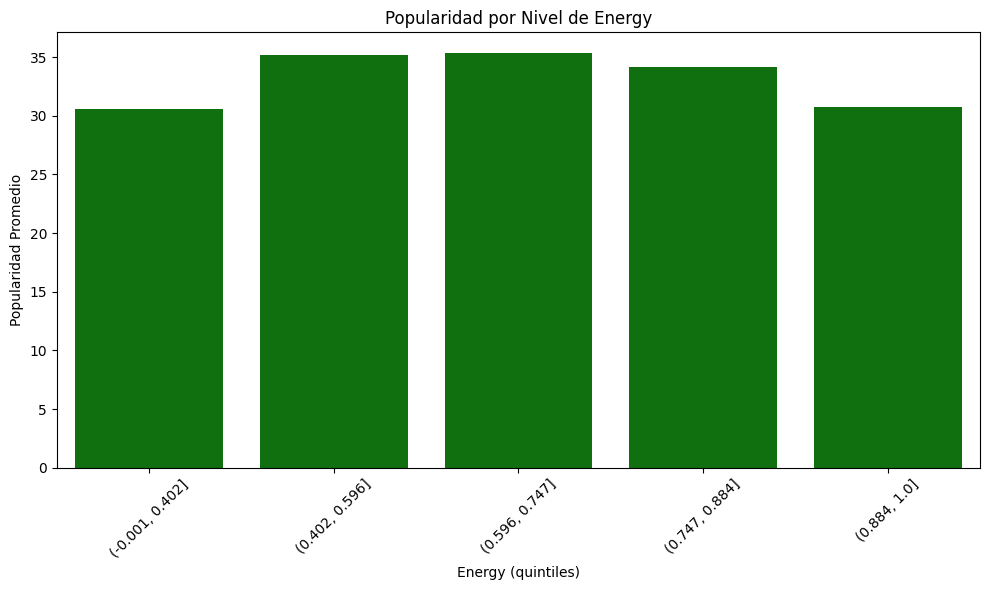

In [22]:
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x=pd.qcut(df['energy'], q=5), y='popularity', 
            color='green', errorbar=None)
plt.title('Popularidad por Nivel de Energy')
plt.xlabel('Energy (quintiles)')
plt.ylabel('Popularidad Promedio')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Aquí notamos un poco que si la canción es enérgica tiende a tener mucha más popularidad que el resto. De la barra 2 a la barra 4 la popularidad es más alta en comparación con la 1 y la 5

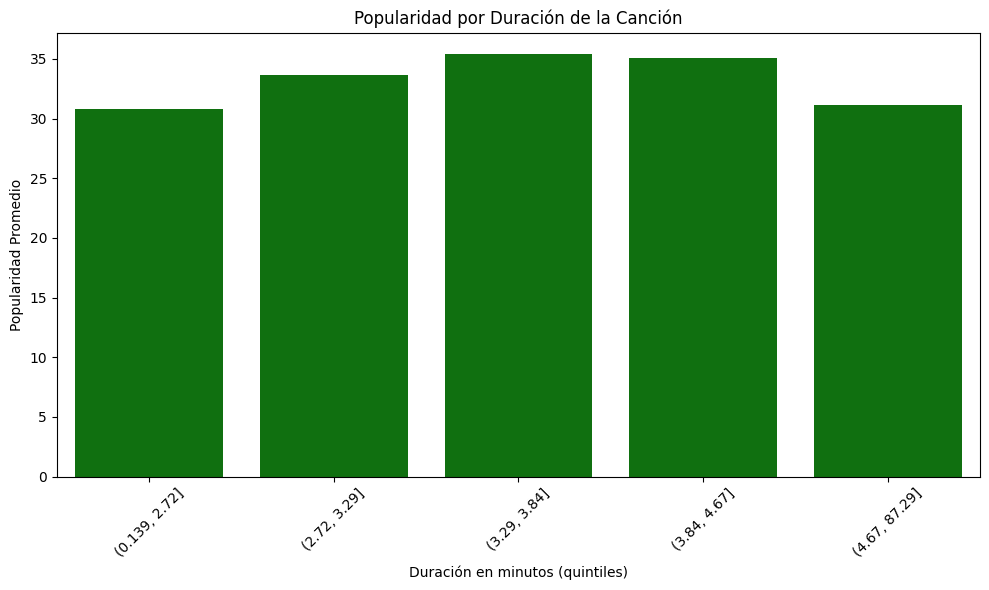

In [23]:
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x=pd.qcut(df['duration_min'], q=5), y='popularity',
            color='green', errorbar=None)
plt.title('Popularidad por Duración de la Canción')
plt.xlabel('Duración en minutos (quintiles)')
plt.ylabel('Popularidad Promedio')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Y vemos que una duración entre 3.29 y casi 4 minutos es la clave para una canción famosa. 

+ La última barra tiene un valor de 87.29 minutos, es debido a que spotify también maneja podcast y canciones. Aunque no son muy relevantes

/tmp/ipykernel_6149/3477771804.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='genre_category', y='popularity', order=genre_order,


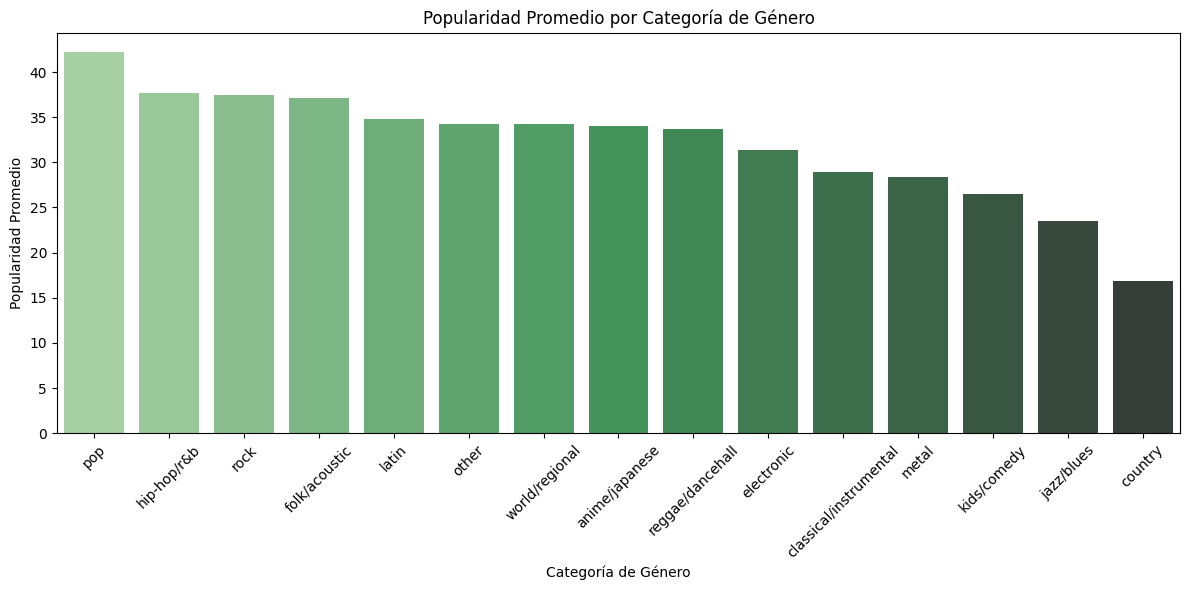

In [69]:
plt.figure(figsize=(12, 6))
genre_order = df.groupby('genre_category')['popularity'].mean().sort_values(ascending=False).index
sns.barplot(data=df, x='genre_category', y='popularity', order=genre_order,
            palette='Greens_d', errorbar=None)
plt.title('Popularidad Promedio por Categoría de Género')
plt.xlabel('Categoría de Género')
plt.ylabel('Popularidad Promedio')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Anteriormente vimos que el pop era el más nominado a los grammys y curiosamente también es el más popular

/tmp/ipykernel_6149/92033841.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  scatter = sns.scatterplot(data=df, y='artist_followers', x='artist_popularity', palette=['#2ca02c', '#98df8a'])


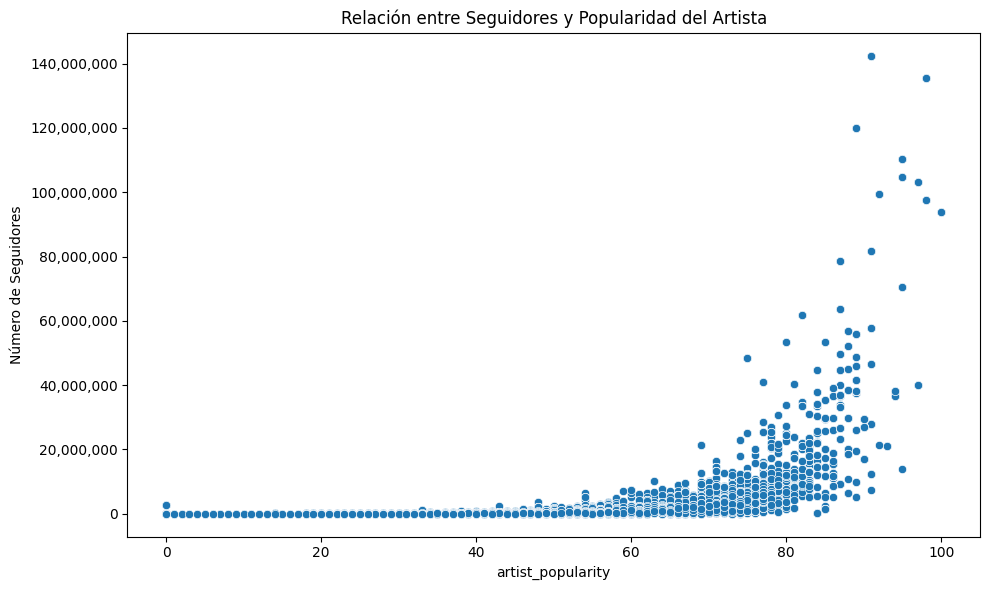

In [76]:
plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(data=df, y='artist_followers', x='artist_popularity', palette=['#2ca02c', '#98df8a'])

plt.gca().get_yaxis().set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
plt.gca().get_xaxis().set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))

plt.title('Relación entre Seguidores y Popularidad del Artista')
plt.ylabel('Número de Seguidores')

plt.tight_layout()
plt.show()

Relación: A mayor cantidad de seguidores mayor popularidad y viceversa

/tmp/ipykernel_6149/2004191381.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='has_grammy_nomination', y='popularity',


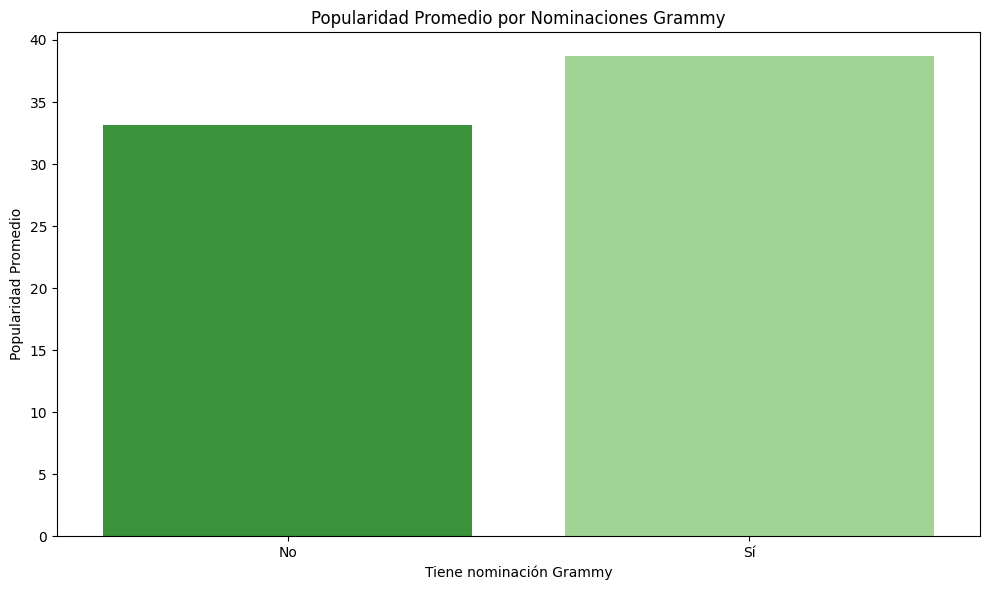

In [74]:
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='has_grammy_nomination', y='popularity',
            palette=['#2ca02c', '#98df8a'], errorbar=None)
plt.title('Popularidad Promedio por Nominaciones Grammy')
plt.xlabel('Tiene nominación Grammy')
plt.ylabel('Popularidad Promedio')
plt.xticks([0, 1], ['No', 'Sí'])
plt.tight_layout()
plt.show()

Si la canción es popular probablemente tenga más posibilidad de ser nominada

Fin del EDA del dataset combinado (merge.csv)